In [1]:
install.packages("properties")
library(properties)

envProps <- read.properties("../env.properties")

Sys.setenv(
    "AWS_ACCESS_KEY_ID" = envProps$access_key, 
    "AWS_SECRET_ACCESS_KEY" = envProps$secret_key,
    "AWS_DEFAULT_REGION" = 'us-east-1')


Warning message in readLines(file):
“incomplete final line found on '../env.properties'”


# Simple RStudio Use Case

Clear the workspace

In [2]:
rm(list = ls())

In [3]:
if (!'tidymodels' %in% installed.packages()) {install.packages('tidymodels', repos='https://packagemanager.rstudio.com/all/__linux__/bionic/latest')}

also installing the dependencies ‘warp’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘furrr’, ‘slider’, ‘doFuture’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
if (!'tidyverse' %in% installed.packages()) {install.packages('tidyverse')}
suppressWarnings(library(tidyverse))
suppressWarnings(library(tidymodels))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Downloading and Processing the Dataset
The model uses the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone)
from the UCI Machine Learning Repository.

In [5]:
abalone <- read_csv(file = 'dataset/abalone.csv', col_names = FALSE)
names(abalone) <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
head(abalone)

Rows: 4177 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1
dbl (8): X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


The output above shows that `sex` is a factor data type but is currently a
character data type (F is Female, M is male, and I is infant). Change `sex` to a
factor and view the statistical summary of the dataset:

In [8]:
abalone <- abalone %>%
  mutate(sex = as_factor(sex))

In [9]:
summary(abalone)

 sex          length         diameter          height        whole_weight   
 M:1528   Min.   :0.075   Min.   :0.0550   Min.   :0.0000   Min.   :0.0020  
 F:1307   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4415  
 I:1342   Median :0.545   Median :0.4250   Median :0.1400   Median :0.7995  
          Mean   :0.524   Mean   :0.4079   Mean   :0.1395   Mean   :0.8287  
          3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1530  
          Max.   :0.815   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 shucked_weight   viscera_weight    shell_weight        rings       
 Min.   :0.0010   Min.   :0.0005   Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1860   1st Qu.:0.0935   1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360   Median :0.1710   Median :0.2340   Median : 9.000  
 Mean   :0.3594   Mean   :0.1806   Mean   :0.2388   Mean   : 9.934  
 3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3290   3rd Qu.:11.000  
 Max.   :1.4880   Max.   :0.7600   Max.   :1.00

The summary above shows that the minimum value for `height` is 0.

Visually explore which abalones have `height` equal to 0 by plotting the
relationship between `rings` and `height` for each value of `sex`:

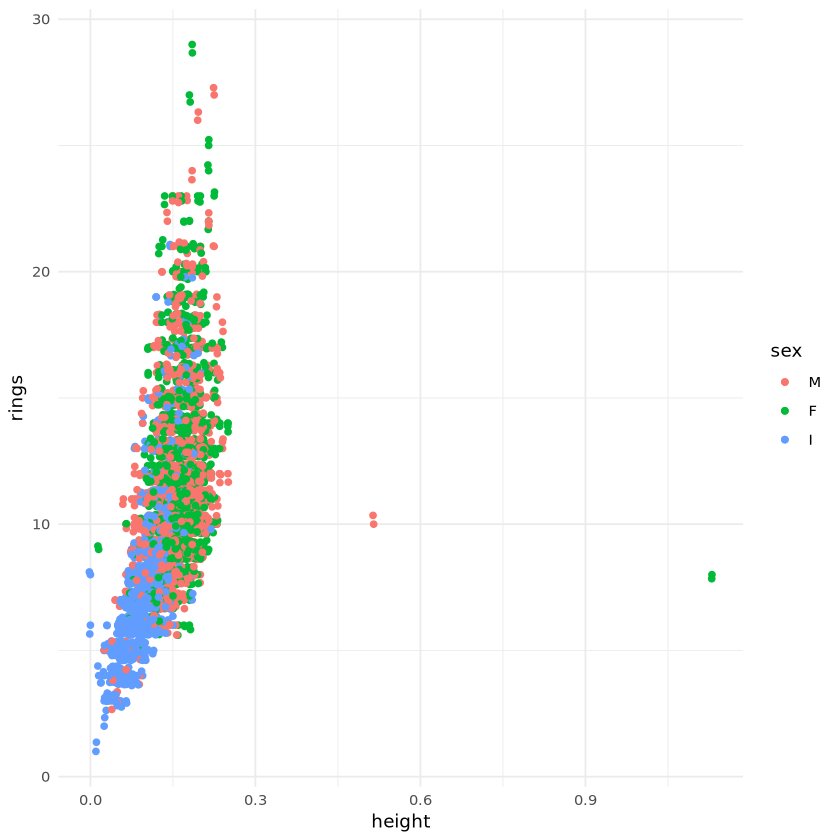

In [10]:
abalone %>%
  ggplot(aes(x = height, y = rings, color = sex)) +
  geom_point() +
  geom_jitter() +
  theme_minimal()

The plot shows multiple outliers: two infant abalones with a height of 0 and a
few female and male abalones with greater heights than the rest. Let’s filter
out the two infant abalones with a height of 0.

In [11]:
abalone <- abalone %>%
  filter(height != 0)

head(abalone)

sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


## Preparing the Dataset for Model Training

The model needs three datasets: one for training, testing, and validation.
First, convert `sex` into a dummy variable and move the target, `rings`, to the
first column. Amazon SageMaker algorithm require the target to be in the first
column of the dataset.

In [12]:
abalone <- abalone %>%
  mutate(female = as.integer(ifelse(sex == 'F', 1, 0)),
         male = as.integer(ifelse(sex == 'M', 1, 0)),
         infant = as.integer(ifelse(sex == 'I', 1, 0))) %>%
  select(-sex)
abalone <- abalone %>%
  select(rings:infant, length:shell_weight)
head(abalone)

rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,0,1,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
7,0,1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
9,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
10,0,1,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
7,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
8,0,0,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120


Sample data for model training

In [13]:
set.seed(42)
abalone_train <- abalone %>%
  sample_frac(size = 0.7)
abalone <- anti_join(abalone, abalone_train)
abalone_test <- abalone %>%
  sample_frac(size = 0.5)
abalone_valid <- anti_join(abalone, abalone_test)

Joining with `by = join_by(rings, female, male, infant, length, diameter,
height, whole_weight, shucked_weight, viscera_weight, shell_weight)`
Joining with `by = join_by(rings, female, male, infant, length, diameter,
height, whole_weight, shucked_weight, viscera_weight, shell_weight)`


In [14]:

lm_model <- linear_reg() %>%
            set_engine('lm') %>% 
            set_mode('regression')

In [15]:

lm_fit <- lm_model %>%
          fit(rings ~ ., data = abalone_train)

In [16]:
summary(lm_fit$fit)


Call:
stats::lm(formula = rings ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2769 -1.2959 -0.3220  0.8369 13.9961 

Coefficients: (1 not defined because of singularities)
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.1859     0.3203   9.947  < 2e-16 ***
female           0.9442     0.1218   7.752 1.24e-14 ***
male             0.9588     0.1132   8.467  < 2e-16 ***
infant               NA         NA      NA       NA    
length          -0.6564     2.1514  -0.305     0.76    
diameter        11.6201     2.6494   4.386 1.20e-05 ***
height           7.9790     1.6630   4.798 1.68e-06 ***
whole_weight     8.2711     0.8607   9.610  < 2e-16 ***
shucked_weight -19.1677     0.9764 -19.632  < 2e-16 ***
viscera_weight  -9.6986     1.5505  -6.255 4.56e-10 ***
shell_weight    10.0007     1.3180   7.588 4.36e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.183 on 2912 degrees of freedom
M

In [17]:
test_results <- predict(lm_fit, new_data = abalone_test) %>%
                            bind_cols(abalone_test)
head(test_results)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


.pred,rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.728013,10,0,1,0,0.595,0.480,0.185,1.1785,0.5260,0.2975,0.3140
8.097811,7,0,0,1,0.440,0.330,0.110,0.3705,0.1545,0.0840,0.1200
11.977887,13,0,1,0,0.650,0.515,0.180,1.3315,0.5665,0.3470,0.4050
10.052089,11,0,0,1,0.520,0.380,0.140,0.5250,0.1775,0.1150,0.1850
13.284333,12,1,0,0,0.610,0.495,0.185,1.1085,0.3705,0.3135,0.3300
10.565131,10,1,0,0,0.485,0.375,0.135,0.5560,0.1925,0.1315,0.1685


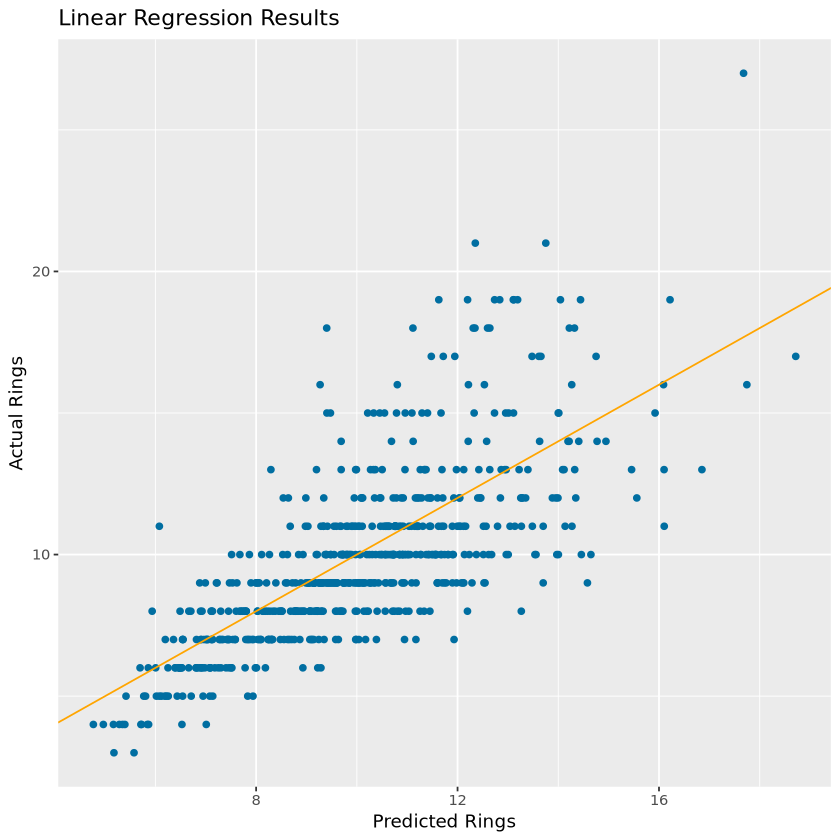

In [18]:
ggplot(data = test_results,
       mapping = aes(x = .pred, y = rings)) +
  geom_point(color = '#006EA1') +
  geom_abline(intercept = 0, slope = 1, color = 'orange') +
  labs(title = 'Linear Regression Results',
       x = 'Predicted Rings',
       y = 'Actual Rings')